In [1]:
import spacy
import re
import pandas as pd

In [6]:
# Load the SpaCy model (install with `python -m spacy download en_core_web_md`)
nlp = spacy.load("en_core_web_sm")

In [7]:
def extract_company_names(text):
    """
    Extracts company names from a given text using SpaCy NER and regex patterns.

    Args:
        text (str): Input text containing potential company names.

    Returns:
        list: A list of extracted company names, sorted and deduplicated.
    """
    # Extract organizations using SpaCy NER
    doc = nlp(text)
    spacy_companies = [ent.text for ent in doc.ents if ent.label_ == "ORG"]

    # Define common company suffixes (expand this list as needed)
    suffixes = [
        "Inc", "Inc.", "Ltd", "Ltd.", "LLC", "Corp", "Corp.", "Corporation",
        "GmbH", "S.A.", "Co", "Co.", "PLC", "LLP", "Pvt. Ltd.", "Limited",
        "AG", "S.A.S.", "NV", "AB", "AS", "SA", "Bhd", "Plc", "L.P.", "Group",
        "Holdings", "Enterprises", "Solutions", "Technologies", "International"
    ]

    # Sort suffixes by descending length to prioritize longer matches
    suffixes_sorted = sorted(suffixes, key=lambda s: len(s), reverse=True)
    suffix_pattern = '|'.join(map(re.escape, suffixes_sorted))

    # Regex pattern to match company names with suffixes (case-insensitive suffixes)
    # Allows apostrophes and hyphens in company names (e.g., "O'Neil Consulting Inc.")
    company_pattern = rf'''
        \b                      # Word boundary
        (                       # Company name part (captured)
            [A-Z]               # Starts with uppercase letter
            [a-zA-Z\'\-]+       # Followed by letters, apostrophes, or hyphens
            (?:\s+              # One or more whitespace
            [A-Z]               # Next word starts with uppercase
            [a-zA-Z\'\-]+       # Followed by letters, apostrophes, or hyphens
            )*                  # Repeat for multi-word names
        )
        \s+                     # Whitespace before suffix
        ((?i:{suffix_pattern})) # Case-insensitive suffix (captured)
        \b                      # Word boundary
    '''

    # Find all regex matches
    regex_companies = []
    for match in re.finditer(company_pattern, text, flags=re.VERBOSE):
        name_part = match.group(1)
        suffix = match.group(2)
        full_name = f"{name_part} {suffix}"
        regex_companies.append(full_name)

    # Combine results and deduplicate
    combined = list(set(spacy_companies + regex_companies))
    combined.sort()
    return combined

In [8]:
# Example usage
if __name__ == "__main__":
    sample_text = """
    Apple Inc. announced a partnership with XYZ Corporation. Tesla and SpaceX,
    based in California, are expanding. A startup called HealthTech Pvt. Ltd.
    joined the market. Google's parent, Alphabet Inc., also participated.
    Siemens AG and JPMorgan Chase & Co. were mentioned.
    """
    companies = extract_company_names(sample_text)
    print("Extracted Company Names:")
    for name in companies:
        print(f"- {name}")

Extracted Company Names:
- Alphabet Inc
- Alphabet Inc.
- Apple Inc
- Apple Inc.
- Google
- HealthTech Pvt
- JPMorgan Chase & Co.
- Siemens AG
- XYZ Corporation


In [9]:
import json

In [10]:
#Company news are available in yearly json files; this function will read json files and bring the json file in google colab

def read_json_file(file_path):
    """
    Reads a JSON file and returns its content as a Python object.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict or list: The content of the JSON file as a Python dictionary or list,
                     or None if an error occurs.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: File not found at '{file_path}'")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in '{file_path}'")
        return None
    except Exception as e:
         print(f"An unexpected error occurred: {e}")
         return None

In [11]:
#json files for each year are uploaded in this folder in google colab
file_path = '/content/2023_processed.json'
data_json_2023 = read_json_file(file_path)

In [12]:
#Location of the news data: https://huggingface.co/datasets/luckycat37/financial-news-dataset

In [8]:
file_path = '/content/2018_processed.json'
data_2018 = read_json_file(file_path)
#data_2018_df = pd.DataFrame(data_2018)

In [13]:
#json files contains a long list of features; only selected columns are fetched into the dataframe format

def json_to_dataframe_selected_keys(json_data, keys_to_extract):
    """
    Converts a JSON string or a list of JSON-like dictionaries to a Pandas DataFrame,
    selecting only the specified keys.

    Args:
        json_data (str or list): A JSON string or a list of dictionaries.
                                   Each dictionary in the list (or the dictionary
                                   parsed from the JSON string) is expected to have
                                   the keys you want to extract.
        keys_to_extract (list): A list of keys whose values you want to include
                                in the DataFrame.

    Returns:
        pandas.DataFrame: A DataFrame containing the values for the selected keys.
                          Returns an empty DataFrame if the input is invalid or
                          no data is processed.
    """
    try:
        if isinstance(json_data, str):
            data = json.loads(json_data)
            if isinstance(data, dict):
                data = [data]  # Handle single JSON object
        elif isinstance(json_data, list):
            data = json_data
        else:
            print("Error: Input 'json_data' must be a JSON string or a list of dictionaries.")
            return pd.DataFrame()

        extracted_data = []
        for item in data:
            row = {}
            for key in keys_to_extract:
                if key in item:
                    row[key] = item[key]
                else:
                    row[key] = None  # Or you could choose to skip missing keys
            extracted_data.append(row)

        df = pd.DataFrame(extracted_data)
        return df

    except json.JSONDecodeError:
        print("Error: Invalid JSON string provided.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()

In [14]:
#some columns are still in json format with multiple entities in one columns; expanding the json json cells into multiple rows, with one entity in one column

def expand_json_column(df, json_column):
    """
    Separates a column containing JSON dictionaries into new key-wise columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        json_column (str): The name of the column containing JSON dictionaries.

    Returns:
        pd.DataFrame: A new DataFrame with the JSON data expanded into columns.
    """
    # Apply json.loads to convert stringified JSON to dictionaries, handling potential errors
    try:
        df[json_column] = df[json_column].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON in column '{json_column}': {e}")
        return df  # Return the original DataFrame if there's a decoding error

    # Handle cases where the column might contain non-dictionary values or NaNs
    expanded_data = []
    for index, row in df.iterrows():
        json_data = row[json_column]
        if isinstance(json_data, dict):
            expanded_data.append(json_data)
        else:
            expanded_data.append({})  # Append an empty dictionary for non-dictionary values

    # Create a new DataFrame from the list of dictionaries
    expanded_df = pd.DataFrame(expanded_data, index=df.index)

    # Concatenate the new columns with the original DataFrame (excluding the JSON column)
    df_expanded = pd.concat([df.drop(columns=[json_column]), expanded_df], axis=1)

    return df_expanded

In [15]:
#entities are still in json format; converting json columns into separate columns

def json_to_df_org_entities(json_data):
    keys = ['date_publish', 'maintext', 'mentioned_companies', 'named_entities']
    df_orgen = json_to_dataframe_selected_keys(json_data, keys)
    df_orgen['org_entities'] = [[] for _ in range(len(df_orgen))]  # Create a list of empty lists with the same length as the DataFrame

    # Extract 'named_entities' if present; if 'named_entities' in data_item; Extend keys with 'word' from ORG entities
    for i, data_item in enumerate(df_orgen['named_entities']):
        df_orgen.loc[i, 'org_entities'].extend([entity for entity in data_item if entity['entity_group'] == 'ORG'])

    df_orgen.drop(columns=['named_entities'], inplace=True)

    df_orgen = df_orgen.explode('org_entities')

    df_orgene = expand_json_column(df_orgen, 'org_entities')

    df_orgene.drop(columns=['entity_group', 'normalized'], inplace=True)

    return df_orgene

In [16]:
df_2023 = json_to_df_org_entities(data_json_2023)

In [17]:
df_2023.shape

(75171, 8)

In [18]:
df_2023.head(10)

,date_publish,maintext,mentioned_companies,word,company_key,start,end,score
0,2023-06-23 05:38:00,"LOS GATOS, Calif. (AP) — At Tyler Malek's ice ...",[C],C,C,754,755,0.751716
1,2023-08-26 14:00:17,"The worst result, after buying shares in a com...",[T],T,T,1633,1634,0.965930
2,2023-12-06 16:57:28,(Bloomberg) -- An insolvency filing by Signa H...,[BA],Ba,BA,1864,1866,0.866735
3,2023-06-14 07:21:56,By John Revill\nZURICH (Reuters) - Swiss citiz...,[GOOGL],Google,GOOGL,1015,1021,0.995022
4,2023-01-10 20:23:00,"WAXHAW, N.C., Jan. 10, 2023 /PRNewswire/ -- Na...",[MA],Ma,MA,773,775,0.682062
4,2023-01-10 20:23:00,"WAXHAW, N.C., Jan. 10, 2023 /PRNewswire/ -- Na...",[MA],Ma,MA,1128,1130,0.815940
5,2023-09-11 02:03:41,By Scott Murdoch\nSYDNEY (Reuters) - Asia stoc...,"[BABA, WFC]",Alibaba Group,BABA,527,540,0.999194
5,2023-09-11 02:03:41,By Scott Murdoch\nSYDNEY (Reuters) - Asia stoc...,"[BABA, WFC]",Wells Fargo,WFC,873,884,0.970640
6,2023-09-12 04:07:10,US tech stocks surged on Monday after Tesla re...,[TSLA],Tesla,TSLA,38,43,0.994540
6,2023-09-12 04:07:10,US tech stocks surged on Monday after Tesla re...,[TSLA],Tesla,TSLA,92,97,0.994072


In [19]:
df_2023[df_2023['mentioned_companies'].apply(len) >1].iloc[6015:6030]

,date_publish,maintext,mentioned_companies,word,company_key,start,end,score
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Microsoft,MSFT,588,597,0.996445
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Google,GOOGL,1121,1127,0.988628
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Microsoft,MSFT,1144,1153,0.995706
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Microsoft,MSFT,1272,1281,0.996211
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Microsoft,MSFT,1473,1482,0.997328
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Microsoft,MSFT,1649,1658,0.997093
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Microsoft,MSFT,1902,1911,0.973336
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Amazon,AMZN,2065,2071,0.868976
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Microsoft,MSFT,2224,2233,0.979509
4231,2023-06-29 15:00:29,Microsoft (MSFT) is continuing to pile generat...,"[MSFT, GOOGL, AMZN]",Google,GOOGL,2304,2310,0.972302


In [20]:
# Set the option to display the full width of columns
pd.set_option('display.max_colwidth', 200)

In [ ]:
# Merge DataFrames vertically using concat
#df = pd.concat([df_2017e,df_2018e], ignore_index=True, sort=False)

In [23]:
df = df_2023

In [24]:
df.shape

(75171, 8)

In [ ]:
# Merge DataFrames vertically using concat
#df = pd.concat([df,df_2023e], ignore_index=True, sort=False)

In [25]:
df.shape

(75171, 8)

In [26]:
df['text_len'] = df['maintext'].apply(len)

In [27]:
df['mentioned_companies_count'] = df['mentioned_companies'].apply(len)

In [28]:
df['mentioned_companies'] = df['mentioned_companies'].apply(tuple)

In [29]:
df.head()

,date_publish,maintext,mentioned_companies,word,company_key,start,end,score,text_len,mentioned_companies_count
0,2023-06-23 05:38:00,"LOS GATOS, Calif. (AP) — At Tyler Malek's ice cream parlors, one cook's trash is another chef's frosty treat.\nThe head ice cream maker at the Portland, Oregon-based Salt & Straw uses the whey lef...","(C,)",C,C,754,755,0.751716,3783,1
1,2023-08-26 14:00:17,"The worst result, after buying shares in a company (assuming no leverage), would be if you lose all the money you put in. But in contrast you can make much more than 100% if the company does well....","(T,)",T,T,1633,1634,0.965930,3098,1
2,2023-12-06 16:57:28,(Bloomberg) -- An insolvency filing by Signa Holding shines some light on the complex dealings of the umbrella organization of Rene Benko’s property and retail empire.\nMost Read from Bloomberg\nB...,"(BA,)",Ba,BA,1864,1866,0.866735,5302,1
3,2023-06-14 07:21:56,"By John Revill\nZURICH (Reuters) - Swiss citizens vote this weekend on whether to raise business tax to 15% from an average of 11% to align with a global minimum tax rate, although even with the r...","(GOOGL,)",Google,GOOGL,1015,1021,0.995022,3530,1
4,2023-01-10 20:23:00,"WAXHAW, N.C., Jan. 10, 2023 /PRNewswire/ -- Nationally recognized branding agency HAVEN CreativeⓇ looks to expand its services further into the Southeast region of the United States after a record...","(MA,)",Ma,MA,773,775,0.682062,2653,1


In [ ]:
df.sample(20)

,date_publish,maintext,mentioned_companies,word,company_key,start,end,score,text_len,mentioned_companies_count
166,2018-12-18 16:44:39,As the ugly headlines keep coming for Facebook...,"(GOOGL, META, T)",Facebook,META,2496,2504,0.991434,4334,3
46,2018-11-20 02:01:56,"It’s been many years in the making, but NASA’s...","(AAPL, AMZN)",Apple,AAPL,2191,2196,0.978649,2250,2
157,2018-04-22 21:33:16,Dating in any dense metropolitan area can seem...,"(AAPL, GOOGL, SQ, AMZN, META, NFLX)",Google,GOOGL,784,790,0.996164,3003,6
184,2018-12-27 21:00:00,"(Bloomberg) -- Sony Corp., the biggest maker o...","(AAPL, GOOGL)",Alphabet Inc,GOOGL,1427,1439,0.999314,3725,2
161,2018-11-21 21:54:57,With many of this Black Friday’s most popular ...,"(AMZN,)",Amazon,AMZN,172,178,0.994054,2924,1
81,2018-05-08 17:17:17,Google Photos already makes it easy for users ...,"(GOOGL,)",Google,GOOGL,1942,1948,0.972946,2696,1
218,2018-12-24 14:33:31,The social network people once couldn’t stay a...,"(GOOGL, AAPL, MSFT, AMZN, META, NFLX)",Facebook,META,1471,1479,0.956311,3957,6
344,2018-11-06 18:55:38,America’s largest online retailer looks like i...,"(AMZN,)",AMZN,AMZN,108,112,0.993115,4055,1
40,2018-06-01 00:00:00,"By Harriet McLeod\nNORTH CHARLESTON, S.C. (Reu...","(BA,)",Boeing,BA,1905,1911,0.997722,3682,1
244,2018-06-04 18:11:01,More and more people are worried about the det...,"(AAPL, GOOGL)",Apple,AAPL,2141,2146,0.994250,2987,2


In [30]:
import re

def clean_text(text):
    """Removes control characters from text."""
    return re.sub(r'[\x00-\x1F\x7F-\x9F]', ' ', text)

df['maintext'] = df['maintext'].apply(clean_text)
df['word'] = df['word'].apply(clean_text)

In [31]:
df['maintext'] = df['maintext'].str.replace('\n', ' ')
df['word'] = df['word'].str.replace('\n', ' ')
df.fillna('', inplace=True)

In [70]:
#convert dataframe dict columns to string to download into excel


import openpyxl
import pandas as pd

def save_dataframe_to_excel_preserve_format(df, excel_file_path):
    """
    Saves a large DataFrame to Excel, preserving data and formatting,
    and allows reloading into a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        excel_file_path (str): Path to save the Excel file.
    """

    # 1. Create workbook and worksheet
    workbook = openpyxl.Workbook()
    sheet = workbook.active

    # 2. Write DataFrame headers
    for col_idx, column in enumerate(df.columns):
        sheet.cell(row=1, column=col_idx + 1).value = column

    # 3. Write DataFrame data and apply styles
    for row_idx, row in df.iterrows():
        for col_idx, value in enumerate(row):
            cell = sheet.cell(row=row_idx + 2, column=col_idx + 1)
            # Convert tuples to strings before writing to Excel
            if isinstance(value, tuple):
                cell.value = str(value)
            else:
                cell.value = value
            # Apply styles based on data type or other criteria
            # ...

    # 4. Save the Excel file
    workbook.save(excel_file_path)

    # (Reloading is done using pd.read_excel as before)

In [33]:
# Save DataFrame
save_dataframe_to_excel_preserve_format(df, 'SP500_news_2023_with_company_entities.xlsx')

In [34]:
import openpyxl
import pandas as pd

In [35]:
# Reload DataFrame
reloaded_df = pd.read_excel('SP500_news_2023_with_company_entities.xlsx')

In [36]:
import re

def add_word_count_column(df):
    """Adds a 'word_count' column to the DataFrame.

    Args:
        df: The input DataFrame containing 'maintext' and 'word' columns.

    Returns:
        The DataFrame with the added 'word_count' column.
    """
    def count_word_occurrences(text, word):
        """Counts occurrences of a word in text, ignoring case."""
        text = text.lower()
        word = word.lower()
        return len(re.findall(r'\b' + re.escape(word) + r'\b', text))

    df['word_count'] = df.apply(lambda row: count_word_occurrences(row['maintext'], row['word']), axis=1)
    return df

In [37]:
reloaded_df.head(10)

,date_publish,maintext,mentioned_companies,word,company_key,start,end,score,text_len,mentioned_companies_count
0,2023-06-23 05:38:00,"LOS GATOS, Calif. (AP) — At Tyler Malek's ice cream parlors, one cook's trash is another chef's frosty treat. The head ice cream maker at the Portland, Oregon-based Salt & Straw uses the whey left...","('C',)",C,C,754,755,0.751716,3783,1
1,2023-08-26 14:00:17,"The worst result, after buying shares in a company (assuming no leverage), would be if you lose all the money you put in. But in contrast you can make much more than 100% if the company does well....","('T',)",T,T,1633,1634,0.965930,3098,1
2,2023-12-06 16:57:28,(Bloomberg) -- An insolvency filing by Signa Holding shines some light on the complex dealings of the umbrella organization of Rene Benko’s property and retail empire. Most Read from Bloomberg Bid...,"('BA',)",Ba,BA,1864,1866,0.866735,5302,1
3,2023-06-14 07:21:56,"By John Revill ZURICH (Reuters) - Swiss citizens vote this weekend on whether to raise business tax to 15% from an average of 11% to align with a global minimum tax rate, although even with the ri...","('GOOGL',)",Google,GOOGL,1015,1021,0.995022,3530,1
4,2023-01-10 20:23:00,"WAXHAW, N.C., Jan. 10, 2023 /PRNewswire/ -- Nationally recognized branding agency HAVEN CreativeⓇ looks to expand its services further into the Southeast region of the United States after a record...","('MA',)",Ma,MA,1128,1130,0.815940,2653,1
5,2023-09-11 02:03:41,By Scott Murdoch SYDNEY (Reuters) - Asia stock markets were softer on Monday ahead of U.S inflation September data this week with investors seeking signals about the Federal Reserve's next likely ...,"('BABA', 'WFC')",Wells Fargo,WFC,873,884,0.970640,3173,2
6,2023-09-12 04:07:10,US tech stocks surged on Monday after Tesla received a bullish upgrade from Morgan Stanley. Tesla stock jumped as much as 10% after Morgan Stanley highlighted the company's Dojo supercomputer init...,"('TSLA',)",Tesla,TSLA,762,767,0.861970,2385,1
7,2023-10-30 13:40:20,"Monolithic Power Systems, Inc. (NASDAQ:MPWR) shareholders might be concerned after seeing the share price drop 26% in the last quarter. But that doesn't change the fact that shareholders have rece...","('T',)",T,T,1781,1782,0.948055,3187,1
8,2023-10-15 07:25:35,The main aim of stock picking is to find the market-beating stocks. But the main game is to find enough winners to more than offset the losers So we wouldn't blame long term HomeChoice Internation...,"('T',)",T,T,1660,1661,0.932661,3340,1
9,2023-08-18 11:31:11,"(Bloomberg) -- WeWork Inc., the troubled co-working company on the brink of collapse, is moving forward with a 1-for-40 reverse stock split in a bid to save its listing on the New York Stock Excha...","('GS',)",Goldman,GS,353,360,0.622100,3127,1


In [38]:
reloaded_df = add_word_count_column(reloaded_df)

In [39]:
df1 = reloaded_df.copy()

In [ ]:
#df2 = df1[(df1['text_len'] < 1500) & (df1['date_publish'] > '2023-01-01')]

In [40]:
df1.shape

(24811, 11)

In [57]:
df2 = df1.sample(100)

In [33]:
# Save DataFrame
save_dataframe_to_excel_preserve_format(df1, 'SP500_news_2018v1_with_company_entities.xlsx')

In [41]:
#Text Preprocessing

import re
import spacy

nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Convert text to string if it's not already to handle potential float or other types
    text = str(text)

    # Remove HTML tags and special characters
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text)

    # Basic NLP pipeline
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha]

    return ' '.join(tokens)

In [43]:
s_text = df1['maintext'].iloc[190]

In [44]:
s_text

'(Bloomberg) -- Wheat futures tumbled after the US Department of Agriculture showed domestic production and quarterly stockpiles were bigger than analysts expected. Most Read from Bloomberg Pakistan Rupee Set to Become Top Performing Currency Globally Europe’s Richest Royal Family Builds $300 Billion Finance Empire Top Chinese Scientist Claims India Moon Landing Nowhere Near South Pole Dianne Feinstein, Longest-Serving Female Senator, Dies at 90 UAW Aims For At Least 30% Wage Bump to Woo New Members The agency raised its estimates for US wheat output when most analysts expected a cut. Chicago futures fell more than 6% after the midday report, settling at the lowest in three years. The losses deepened wheat’s fourth straight quarterly decline — the longest such route in 14 years — raising hopes for further relief from food inflation. The surprise forecast stemmed in part from an unexpected boost in yields for spring varieties after rains late in the growing season. While the US is only 

In [45]:
!pip install transformers datasets spacy keybert python-dotenv torch sentencepiece
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [46]:
from transformers import pipeline
from datasets import load_dataset
import spacy
from keybert import KeyBERT
import numpy as np

# Initialize models
nlp = spacy.load("en_core_web_sm")
kw_model = KeyBERT()
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
zero_shot = pipeline("zero-shot-classification",
                    model="facebook/bart-large-mnli")

# Custom financial categories
financial_categories = [
    "Mergers & Acquisitions",
    "Earnings Reports",
    "IPO Listings",
    "Market Analysis",
    "Regulatory Changes",
    "Corporate Governance",
    "Stock Movements",
    "Economic Indicators",
    "Debt Financing",
    "Dividend Announcements"
]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [52]:
from tqdm import tqdm

In [53]:
def process_article(example, total_articles):
    text = example["maintext"]  # Adjust column name based on dataset structure
    company = example["company_key"]
    date = example["date_publish"]
    # Text Summarization
    max_input_length = 1024
    if len(text) > max_input_length:
        text = text[:max_input_length]
    summary = summarizer(text, max_length=90, min_length=30, do_sample=False)[0]['summary_text']

    # Key Phrase Extraction using KeyBERT
    key_phrases = [kp[0] for kp in kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 3),
        stop_words='english',
        top_n=5
    )]

    # Company Extraction using SpaCy NER
    doc = nlp(text)
    companies = list(set([ent.text for ent in doc.ents if ent.label_ == "ORG"]))

    # Financial Topic Classification (Zero-shot)
    topic_results = zero_shot(
        text,
        financial_categories,
        multi_label=True,
        hypothesis_template="This text is about {}."
    )
    topics = {k: v for k, v in zip(topic_results["labels"], topic_results["scores"])}

    # Additional Features
    doc = nlp(text)
    financial_verbs = [token.lemma_ for token in doc if token.pos_ == "VERB" and token.text.lower() in {
        'acquire', 'merge', 'report', 'list', 'regulate', 'govern',
        'trade', 'issue', 'dividend', 'forecast'
    }]

    return {
        "text": text,
        "company": company,
        "date": date,
        "summary": summary,
        "key_phrases": key_phrases,
        "companies": companies,
        "financial_topics": topics,
        "financial_verbs": financial_verbs
    }
    pbar.update(1)

In [64]:
df2 = df1

In [65]:
total_articles = len(df2)
enhanced_dataset = pd.DataFrame()

batch_size = 50  # Adjust as needed
for i in tqdm(range(0, len(df2), batch_size), desc="Processing articles"):
    batch_df = df2.iloc[i:i + batch_size]
    batch_results = batch_df.apply(
        lambda row: process_article(row, total_articles),
        axis=1,
        result_type='expand'
    )
    enhanced_dataset = pd.concat([enhanced_dataset, batch_results], ignore_index=True)

Processing articles:   3%|▎         | 17/497 [18:17<8:40:33, 65.07s/it]Your max_length is set to 90, but your input_length is only 48. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=24)
Your max_length is set to 90, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Processing articles:  11%|█         | 53/497 [56:53<7:56:24, 64.38s/it]Your max_length is set to 90, but your input_length is only 65. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
Your max_length is set to 90, but your input_length is only 77. Since this is a summarization task, where outputs 

In [67]:
# Convert to pandas DataFrame for analysis
df3 = enhanced_dataset

df3["text_len"] = df3["text"].apply(len)
df3["summary_len"] = df3["summary"].apply(len)

# Example analysis
df3[["date","text","text_len","company","summary","summary_len","key_phrases", "companies", "financial_topics"]].head()

,date,text,text_len,company,summary,summary_len,key_phrases,companies,financial_topics
0,2023-06-23 05:38:00,"LOS GATOS, Calif. (AP) — At Tyler Malek's ice cream parlors, one cook's trash is another chef's frosty treat. The head ice cream maker at the Portland, Oregon-based Salt & Straw uses the whey left...",1024,C,Tyler Malek's ice cream chain is among those at the forefront of the upcycling movement. Upcycling is the process of creating high-quality products from leftover food. Trend gaining ground as cons...,243,"[malek ice cream, ice cream maker, flavors like cacao, ice cream chain, cacao pulp chocolate]","[Cacao Pulp & Chocolate Stracciatella Gelato, AP, the Pacific Northwest, Salt & Straw]","{'Market Analysis': 0.7915734648704529, 'Economic Indicators': 0.7278148531913757, 'Regulatory Changes': 0.4440170228481293, 'Stock Movements': 0.42812368273735046, 'Corporate Governance': 0.29434..."
1,2023-08-26 14:00:17,"The worst result, after buying shares in a company (assuming no leverage), would be if you lose all the money you put in. But in contrast you can make much more than 100% if the company does well....",1024,T,"The Baker Hughes Company (NASDAQ:BKR) share price has flown 139% in the last three years. The worst result, after buying shares in a company, would be if you lose all the money you put in. You can...",314,"[baker hughes profitable, surprising share price, share price baker, shareholder returns, good share price]","[EPS, BKR, the Baker Hughes Company, NASDAQ, Baker Hughes]","{'Stock Movements': 0.5671049952507019, 'Corporate Governance': 0.3007490634918213, 'Market Analysis': 0.2784726023674011, 'Economic Indicators': 0.13896462321281433, 'Mergers & Acquisitions': 0.0..."
2,2023-12-06 16:57:28,(Bloomberg) -- An insolvency filing by Signa Holding shines some light on the complex dealings of the umbrella organization of Rene Benko’s property and retail empire. Most Read from Bloomberg Bid...,1024,BA,An insolvency filing by Signa Holding shines some light on the complex dealings of the umbrella organization of Rene Benko's property and retail empire. The scope of entities that Signa owes money...,299,"[signa owes money, firm represented signa, read bloomberg biden, entities signa owes, filing signa holding]","[Fed Wagers, Bloomberg, Fortune India Stock Value, Signa Holding, Rally Driven, Signa]","{'Stock Movements': 0.8786566257476807, 'Debt Financing': 0.5398693084716797, 'Market Analysis': 0.5208959579467773, 'Economic Indicators': 0.5126535892486572, 'Corporate Governance': 0.4735919535..."
3,2023-06-14 07:21:56,"By John Revill ZURICH (Reuters) - Swiss citizens vote this weekend on whether to raise business tax to 15% from an average of 11% to align with a global minimum tax rate, although even with the ri...",1024,GOOGL,Swiss citizens vote this weekend on whether to raise business tax to 15% from an average of 11%. Increase is expected to raise $220 billion globally for governments strapped for cash. Switzerland ...,265,"[swiss government, crisis swiss government, public vote switzerland, swiss citizens vote, vote switzerland]","[GFS Bern, Organisation for Economic Cooperation and Development, COVID-19, Reuters, OECD, Google]","{'Corporate Governance': 0.8134056329727173, 'Economic Indicators': 0.46585819125175476, 'Regulatory Changes': 0.2875955104827881, 'Market Analysis': 0.27295100688934326, 'Earnings Reports': 0.140..."
4,2023-01-10 20:23:00,"WAXHAW, N.C., Jan. 10, 2023 /PRNewswire/ -- Nationally recognized branding agency HAVEN CreativeⓇ looks to expand its services further into the Southeast region of the United States after a record...",1024,MA,"HAVEN is a full-service communications agency that works closely with governments and B2B companies in three time zones and five states. In 2023, HAVEN looks to build relationships with clients in...",231,"[branding agency haven, communities 2023 haven, brand make mavens, make mavens haven, 2022 haven service]","[Founder, HAVEN Creative]","{'Market Analysis':

In [74]:
import openpyxl
import pandas as pd

def save_dataframe_to_excel_workbook_preserve_format(df, excel_file_path):
    """
    Saves a large DataFrame to Excel, preserving data and formatting,
    and allows reloading into a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        excel_file_path (str): Path to save the Excel file.
    """

    # 1. Create workbook and worksheet
    workbook = openpyxl.Workbook()
    sheet = workbook.active

    # 2. Write DataFrame headers
    for col_idx, column in enumerate(df.columns):
        sheet.cell(row=1, column=col_idx + 1).value = column

    # 3. Write DataFrame data and apply styles
    for row_idx, row in df.iterrows():
        for col_idx, value in enumerate(row):
            cell = sheet.cell(row=row_idx + 2, column=col_idx + 1)
            # Convert lists, tuples, and dictionaries to strings before writing to Excel
            if isinstance(value, (list, tuple, dict)):  # Check if value is a list, tuple, or dictionary
                cell.value = str(value) # Convert to string representation
            else:
                cell.value = value

    # 4. Save the Excel file
    workbook.save(excel_file_path)

    # (Reloading is done using pd.read_excel as before)

In [75]:
# Save DataFrame
save_dataframe_to_excel_workbook_preserve_format(df3, 'SP500_news_analysis_2023.xlsx')

In [76]:
import json
import pandas as pd

# ... (Your existing code) ...

def save_dataframe_to_json(df, json_file_path):
    """
    Saves a Pandas DataFrame to a JSON file.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        json_file_path (str): Path to save the JSON file.
    """
    try:
        # Convert DataFrame to JSON records (list of dictionaries)
        json_data = df.to_json(orient='records', lines=False)

        # Write JSON data to file
        with open(json_file_path, 'w') as file:
            json.dump(json.loads(json_data), file, indent=4)  # Use json.loads to handle nested JSON

        print(f"DataFrame saved to '{json_file_path}'")

    except Exception as e:
        print(f"An error occurred while saving to JSON: {e}")


# ... (Rest of your code) ...

# Example usage to save df3 to JSON:
save_dataframe_to_json(df3, 'SP500_news_analysis_2023.json')

DataFrame saved to 'SP500_news_analysis_2023.json'


In [78]:
df3['key_phrases'] = df3['key_phrases'].apply(lambda x: ', '.join(x))

In [79]:
df3.sample(10)

,text,company,date,summary,key_phrases,companies,financial_topics,financial_verbs,text_len,summary_len
24356,Investment in Indonesian-based Pertamina Geothermal Energy marks Masdar's entry into geothermal energy Increases Masdar's footprint in the Asia-Pacific region and gives company access to second-la...,MA,2023-02-24 15:19:00,"UAE clean energy powerhouse Masdar is entering the geothermal energy sector, through a strategic investment in Pertamina Geothermal Energy. The investment marks Masdar's entry into geothermalEnerg...","masdar entry geothermal, geothermal energy sector, investment pertamina geothermal, geothermal energy, entry geothermal energy","[Advanced Technology, Geothermal, Pertamina Geothermal Energy marks Masdar's, ABU DHABI, Masdar, Pertamina Geothermal Energy]","{'Market Analysis': 0.8221186995506287, 'Corporate Governance': 0.66083824634552, 'Stock Movements': 0.6405625939369202, 'Economic Indicators': 0.596931517124176, 'Mergers & Acquisitions': 0.50415...",[],1024,252
14315,"Self-made millionaires may seem like people who must do all of their shopping at high-end stores, buying expensive brands and living large -- after all, isn't that the point of having millions? In...",COST,2023-09-04 13:30:02,Self-made millionaires often achieve their status by being extremely frugal. Todd Bryant and Tom Nardone talk about which items they still buy at Dollar Tree.,"millionaires shop dollar, know millionaires shop, millionaires shop, self millionaires like, self millionaires","[Dignity Lifts, Signature Wealth Partners, Dollar Tree]","{'Economic Indicators': 0.49640166759490967, 'Debt Financing': 0.37525317072868347, 'Market Analysis': 0.37230372428894043, 'Stock Movements': 0.29862040281295776, 'Regulatory Changes': 0.26435050...",[],1024,158
11309,Many investors are still learning about the various metrics that can be useful when analysing a stock. This article is for those who would like to learn about Return On Equity (ROE). By way of lea...,META,2023-10-16 11:09:21,"Return on equity (ROE) is a measure of the profitability of a company. The 'return' is the amount earned after tax over the last twelve months. In our analysis, Constellium's ROE is 27%. That mean...","return equity roe, roe calculated return, worth shareholders equity, equity roe, equity roe important","[Constellium How Is ROE Calculated, Constellium SE, Shareholders, Constellium, NYSE, Return On Equity, CSTM, ROE]","{'Economic Indicators': 0.17666226625442505, 'Market Analysis': 0.158335343003273, 'Stock Movements': 0.08047907054424286, 'Corporate Governance': 0.03120744228363037, 'Earnings Reports': 0.011156...",[],1024,294
20298,Key Insights Significant control over Magellan Financial Group by retail investors implies that the general public has more power to influence management and governance-related decisions A total o...,MA,2023-09-01 01:31:36,"A total of 25 investors have a majority stake in the company with 47% ownership. 43% of Magellan Financial Group is held by Institutions. Retail investors suffered the most losses, but institution...","shareholders magellan financial, shareholders magellan, groups magellan financial, magellan financial group, look shareholders magellan","[The Institutional Ownership Tell Us, ASX, Magellan Financial Group Limited, Magellan Financial Group, MFG]","{'Market Analysis': 0.7041159272193909, 'Stock Movements': 0.5953526496887207, 'Corporate Governance': 0.43112459778785706, 'Economic Indicators': 0.1455676108598709, 'Debt Financing': 0.116130582...",[],1024,232
13430,"VANCOUVER, BC, April 10, 2023 /CNW/ - TSX VENTURE COMPANIES GREENSPACE BRANDS INC. (""JTR.H"") [formerly GreenSpace Brands Inc. (""JTR"")] BULLETIN TYPE: Transfer and New Addition to NEX, Symbol Chang...",T,2023-04-11 02:50:00,"GreenSpace Brands Inc. (the ""Company"") has not maintained the requirements for a TSX Venture Tier 1 company. As of April 12, 2023, the Company is subject to restrictions on share issuances and cer...","tsx venture policy,

In [80]:
df4 = df3

In [81]:
# 1. Get all unique financial topics
all_topics = set()
for topics_dict in df4['financial_topics']:
    all_topics.update(topics_dict.keys())

# 2. Create new columns for each topic with initial values of 0
for topic in all_topics:
    df4[topic] = 0

# 3. Fill in the topic scores from the 'financial_topics' dictionary
for index, row in df4.iterrows():
    for topic, score in row['financial_topics'].items():
        df3.loc[index, topic] = score

# (Optional) Drop the original 'financial_topics' column if not needed
# df3.drop(columns=['financial_topics'], inplace=True)

In [85]:
df4.sample(10)

,company,date,summary,key_phrases,companies,Earnings Reports,IPO Listings,Debt Financing,Corporate Governance,Mergers & Acquisitions,Regulatory Changes,Economic Indicators,Market Analysis,Dividend Announcements,Stock Movements
18240,COST,2023-12-15 22:24:49,"Costco sold $100 million of gold bars last quarter, with each bar selling for a little over $2,000. Yahoo Finance’s Brooke DiPalma, Alexandra Canal, and Pras Subramanian deep dive into this “gold ...","costco cost sold, costco cost, million gold bars, cost sold 100, cost sold","[Costco, Yahoo Finance’s]",0.013161,0.002397,0.004839,0.026545,0.008685,0.036726,0.165922,0.545515,0.003361,0.016234
17071,JPM,2023-10-03 16:52:56,It had been over a year since the market went a month without a SPAC debut. The once-hot market for black checks where dozens were pricing each month just two years ago has gone cold.,"acquisition company debut, exchange 99 acquisition, acquisition company, purpose acquisition company, company debut exchange","[Coming Soon Airbnb, Bloomberg Key Taiwan Tech, Bloomberg, SPAC, 99 Acquisition Group Inc.]",0.174382,0.276002,0.255189,0.424040,0.329382,0.387232,0.805360,0.701582,0.028026,0.943507
16620,SHOP,2023-08-16 09:25:38,"Sea Ltd (NYSE:SE) operates Southeast Asia's largest e-commerce company, Shopee. Shopee is a hybrid C2C and B2C marketplace platform operating in eight core markets. Indonesia accounts for 35% of G...","sea nyse, sea nyse se, se sea nyse, company shopee sea, lending sea nyse","[GuruFocus, Garena, SeaMoney, GMV, NYSE, Sea Ltd, SE Sea Ltd]",0.249600,0.070743,0.159825,0.343267,0.063794,0.232095,0.447073,0.932691,0.061793,0.975631
16093,T,2023-08-08 08:04:47,"This week’s top-selling home in Somerset is a sophisticated ranch that sold for $600,000. With 2,346 square feet of living space, it features a contemporary eat-in kitchen, a large living room, an...","selling home somerset, somerset sophisticated ranch, ranch bedrooms including, home somerset, ranch bedrooms","[Derlene M Sheehan RET, Dartmouth, The Warren Group]",0.127432,0.120680,0.099692,0.079576,0.118360,0.202724,0.396590,0.357771,0.075150,0.138644
23640,T,2023-03-15 23:22:00,"EnWave has granted Mr. Dylan Murray, CFO an aggregate of 300,000 incentive stock options. The options are exercisable at a price of $0.27, being closing price of the Company’s common shares on the...","enwave corporation tsx, enwave company announced, enwave corporation, enwave company, approval tsxv enwave","[Company, TSX, Plan, EnWave, EnWave Corporation, the TSX Venture Exchange, TSXV, the Company’s Stock Option Plan, CFO, BC, GLOBE NEWSWIRE]",0.044676,0.018732,0.004902,0.265924,0.019326,0.126779,0.127277,0.223431,0.011666,0.892746
15873,WFC,2023-12-12 12:50:00,Ark Invest Chief Executive Officer Cathie Wood is known for taking large positions in emerging technology companies. Wood's buying patterns are making one thing clear: She really likes SoFi Techn...,"fintech stocks wood, sofi stock, sofi technologies nasdaq, sofi stock trades, results sofi stock","[Wood, SoFi, Wells Fargo, SoFi Technologies]",0.033946,0.075467,0.105964,0.152319,0.064313,0.154299,0.244580,0.860171,0.031409,0.923550
17896,TSLA,2023-05-15 21:37:57,"Berkshire Hathaway bought shares of financial firm Capital One (COF) in the first quarter. Berkshire also added to its positions in Apple (AAPL), Occidental Petroleum (OXY), Bank of America (BOC),...","berkshire hathaway brk, brk berkshire hathaway, berkshire hathaway, berkshire hathaway released, banking turmoil berkshire","[OXY, Occidental Petroleum, GM, Apple, Citigroup, Capital One, CVX, Bank of America, Chevron, COF, Amazon]",0.029783,0.003334,0.036154,0.138840,0.007028,0.051967,0.082326,0.318173,0.008038,0.824859
13713,C,2023-04-27 16:09:45,"Cricut's (NASDAQ:CRCT) return on capital employed (ROCE) is 12%. In absolute terms, that's a pretty standard return. However, after investigating Cricut, we don't think it's current trends fit the...","capital employed roce, employed roce, bagger stoc

In [86]:
df5=df4

In [87]:
df5.drop(columns=['summary', 'key_phrases', 'companies'], inplace=True)

In [88]:
df5.sample(10)

,company,date,Earnings Reports,IPO Listings,Debt Financing,Corporate Governance,Mergers & Acquisitions,Regulatory Changes,Economic Indicators,Market Analysis,Dividend Announcements,Stock Movements
13218,AAPL,2023-05-01 14:50:24,0.017756,0.032041,0.261334,0.177989,0.033477,0.183741,0.327509,0.721575,0.019175,0.638732
23377,META,2023-04-22 13:14:04,0.239528,0.027931,0.018141,0.141307,0.028333,0.061965,0.325818,0.782100,0.017105,0.811238
15233,META,2023-06-14 10:54:35,0.042139,0.024035,0.039592,0.850871,0.202235,0.097335,0.308734,0.575463,0.050928,0.838182
11164,GS,2023-06-01 23:30:02,0.032526,0.024822,0.165058,0.087268,0.030628,0.102817,0.628646,0.513313,0.016788,0.150705
12214,C,2023-09-07 20:07:10,0.017952,0.008259,0.047961,0.038965,0.007940,0.034613,0.583006,0.359275,0.017684,0.747912
166,AAPL,2023-11-03 13:47:52,0.832419,0.009194,0.037776,0.058231,0.017478,0.134350,0.466378,0.761366,0.013018,0.889782
11046,T,2023-04-14 21:05:00,0.799933,0.037131,0.046302,0.223527,0.025973,0.177781,0.099864,0.523247,0.029073,0.750415
22620,T,2023-07-06 21:16:37,0.023850,0.020533,0.410131,0.054485,0.007413,0.125974,0.601835,0.591288,0.014076,0.183688
12547,T,2023-02-14 08:00:00,0.096180,0.033143,0.069442,0.174211,0.056225,0.218285,0.290310,0.535471,0.042188,0.183394
11636,V,2023-06-02 14:00:25,0.027601,0.010184,0.019535,0.161123,0.019168,0.044521,0.044512,0.826579,0.011430,0.909598


In [89]:
# Save DataFrame
save_dataframe_to_excel_workbook_preserve_format(df5, 'SP500_news_topics_analysis_2023.xlsx')

In [90]:
topic_df = df5

In [103]:
topic_df['yearmon'] = pd.to_datetime(topic_df['date']).dt.to_period('M')

In [105]:
topic_df.drop(columns=['date'], inplace=True)

In [106]:
topic_df.sample(15)

,company,Earnings Reports,IPO Listings,Debt Financing,Corporate Governance,Mergers & Acquisitions,Regulatory Changes,Economic Indicators,Market Analysis,Dividend Announcements,Stock Movements,yearmon
16799,DIS,0.004409,0.005878,0.000696,0.012220,0.001355,0.007995,0.030595,0.252599,0.006471,0.104220,2023-10
12109,TSLA,0.112304,0.053263,0.107158,0.573933,0.080339,0.951063,0.460363,0.626789,0.066942,0.398741,2023-07
10852,V,0.015597,0.016783,0.033062,0.539640,0.034213,0.058983,0.359346,0.864667,0.024051,0.714747,2023-07
24373,BA,0.137178,0.048208,0.069856,0.268821,0.061491,0.136889,0.170966,0.604136,0.084928,0.909742,2023-09
15174,META,0.038699,0.034725,0.055764,0.067490,0.032058,0.160525,0.157355,0.152941,0.028108,0.051849,2023-09
20320,GOOGL,0.128893,0.075380,0.237161,0.579925,0.188966,0.494639,0.835818,0.647806,0.067984,0.543219,2023-01
15785,C,0.049007,0.031110,0.036446,0.145658,0.017835,0.085319,0.263558,0.727565,0.024756,0.852612,2023-09
10723,GOOGL,0.086284,0.062168,0.090713,0.482107,0.062842,0.256722,0.147474,0.520261,0.033896,0.470588,2023-12
7414,META,0.153898,0.063164,0.128588,0.500131,0.066847,0.624951,0.242949,0.513827,0.057627,0.156743,2023-11
14828,TSLA,0.178429,0.037394,0.078284,0.385736,0.093566,0.955725,0.719887,0.573403,0.047995,0.850042,2023-10


In [107]:
company_topic_scores = topic_df.groupby('company').mean().reset_index()

In [111]:
company_topic_scores.drop(columns=['yearmon'], inplace=True)

In [108]:
company_topic_scores.sample(10)

,company,Earnings Reports,IPO Listings,Debt Financing,Corporate Governance,Mergers & Acquisitions,Regulatory Changes,Economic Indicators,Market Analysis,Dividend Announcements,Stock Movements,yearmon
4,BA,0.172875,0.052885,0.119429,0.268079,0.106884,0.233630,0.373664,0.556779,0.071345,0.492795,2023-06
5,BABA,0.193746,0.169215,0.191987,0.347198,0.131515,0.369253,0.485095,0.612237,0.050010,0.699400,2023-06
22,KO,0.176242,0.080256,0.131696,0.300268,0.103524,0.196888,0.396138,0.543979,0.063315,0.524497,2023-06
27,MRNA,0.143823,0.046549,0.133756,0.304793,0.111887,0.299985,0.381506,0.555470,0.045391,0.610733,2023-07
7,BRK,0.175390,0.041553,0.177847,0.284930,0.083992,0.231680,0.401236,0.605122,0.103241,0.691458,2023-07
36,PYPL,0.228515,0.051436,0.207439,0.307485,0.088484,0.287347,0.406881,0.562467,0.050829,0.522296,2023-06
14,DIS,0.198370,0.061355,0.129737,0.331613,0.119956,0.252142,0.399702,0.527878,0.063339,0.564498,2023-07
23,LLY,0.141362,0.047912,0.073925,0.213717,0.109100,0.209708,0.302247,0.543209,0.079972,0.614225,2023-06
30,NFLX,0.258588,0.059821,0.203655,0.293738,0.109858,0.301006,0.476050,0.620025,0.055436,0.633015,2023-07
11,CRM,0.206855,0.054015,0.132132,0.318432,0.109429,0.194035,0.366483,0.555882,0.040794,0.568523,2023-05


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [98]:
company_topic_counts = topic_df.groupby('company').count().reset_index()

In [99]:
company_topic_counts

,company,date,Earnings Reports,IPO Listings,Debt Financing,Corporate Governance,Mergers & Acquisitions,Regulatory Changes,Economic Indicators,Market Analysis,Dividend Announcements,Stock Movements
0,AAPL,1431,1431,1431,1431,1431,1431,1431,1431,1431,1431,1431
1,ADBE,94,94,94,94,94,94,94,94,94,94,94
2,AMZN,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300
3,AVGO,46,46,46,46,46,46,46,46,46,46,46
4,BA,585,585,585,585,585,585,585,585,585,585,585
5,BABA,340,340,340,340,340,340,340,340,340,340,340
6,BAC,383,383,383,383,383,383,383,383,383,383,383
7,BRK,397,397,397,397,397,397,397,397,397,397,397
8,C,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616,3616
9,CMCSA,45,45,45,45,45,45,45,45,45,45,45


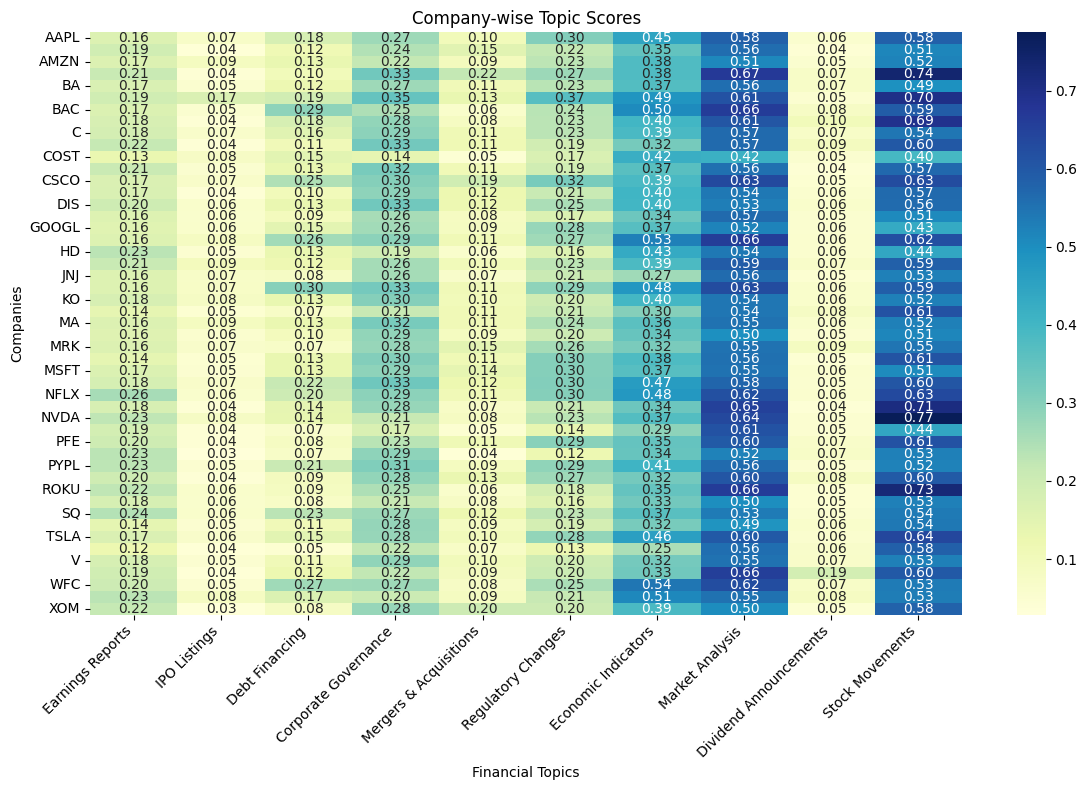

In [112]:
plt.figure(figsize=(12, 8))
sns.heatmap(company_topic_scores.set_index('company'), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title('Company-wise Topic Scores')
plt.xlabel('Financial Topics')
plt.ylabel('Companies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

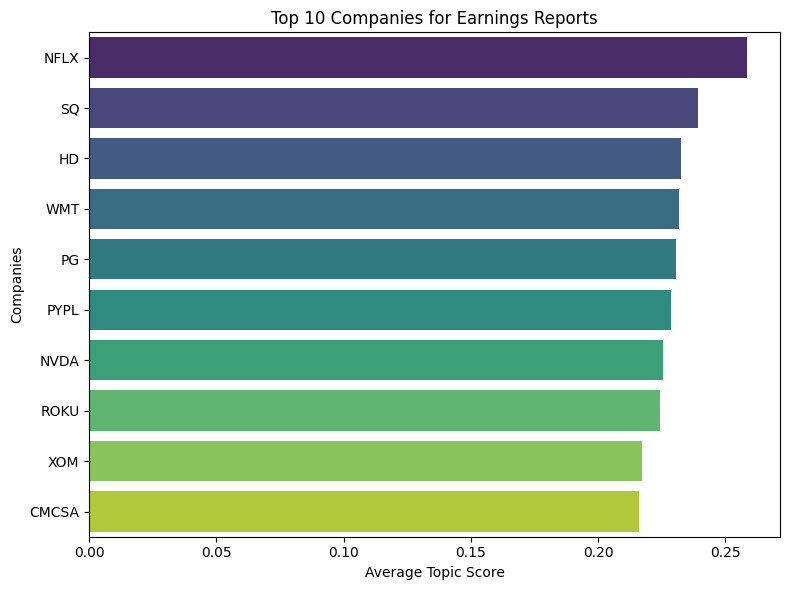

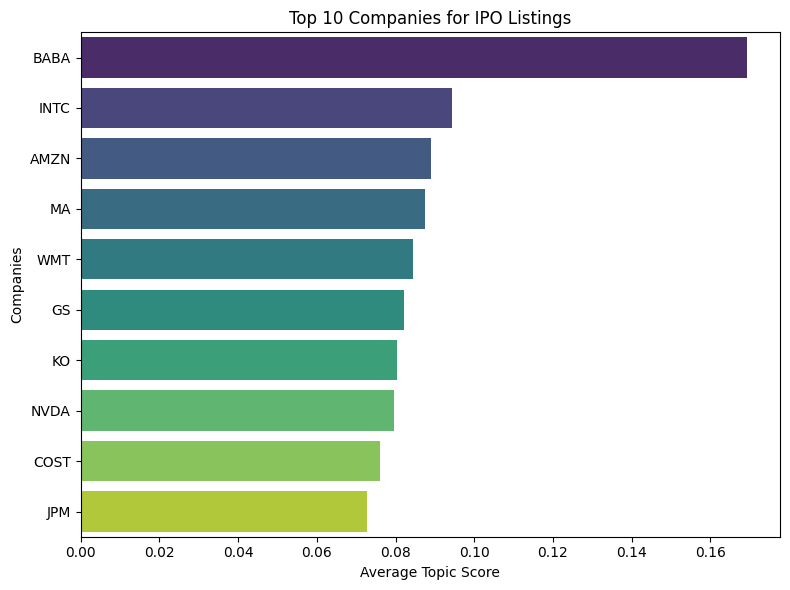

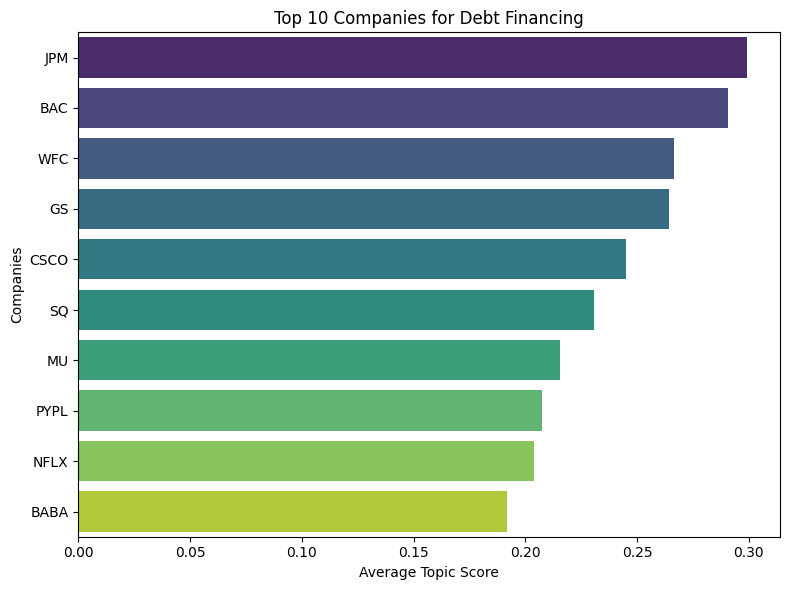

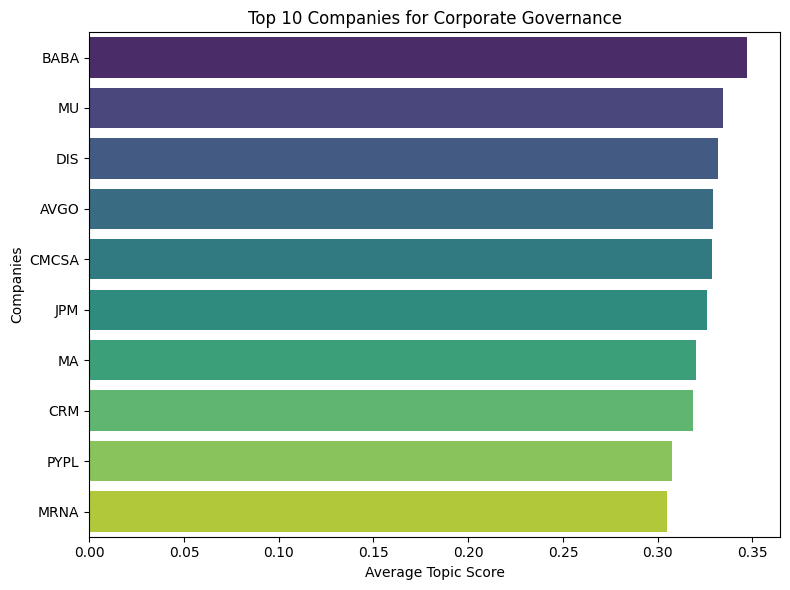

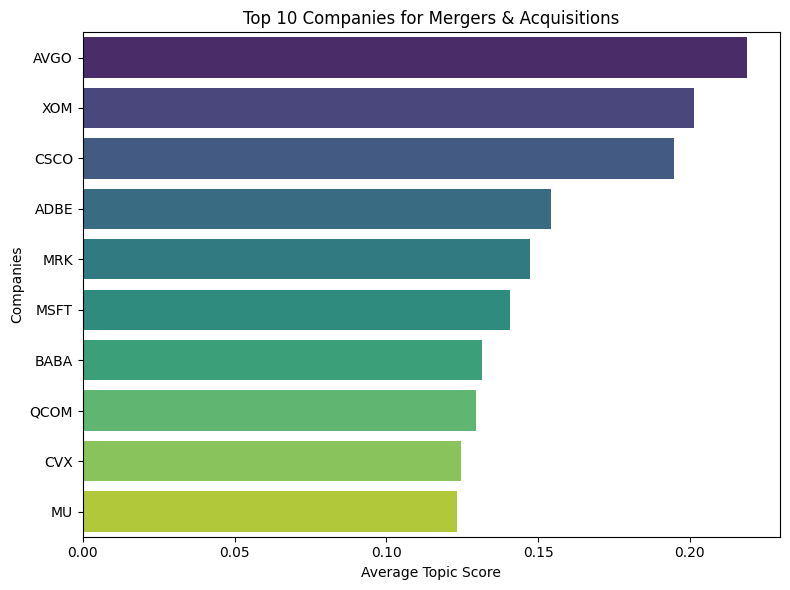

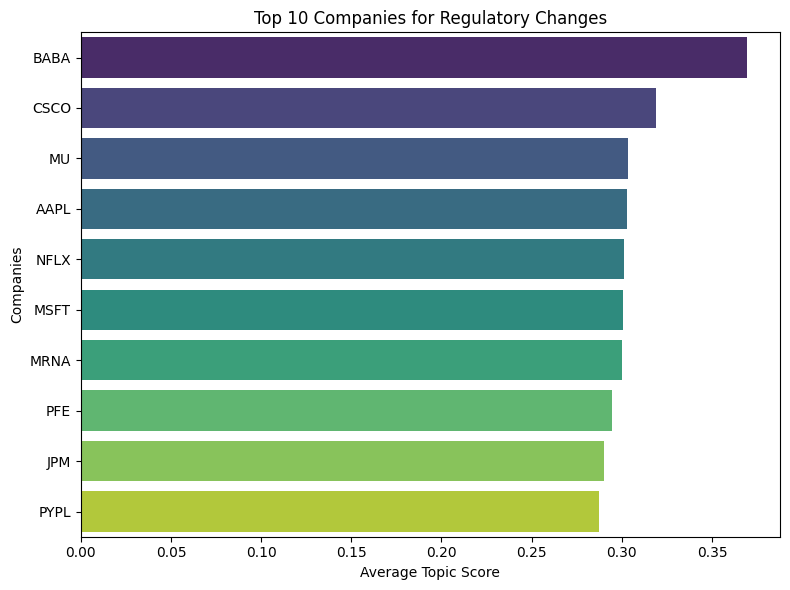

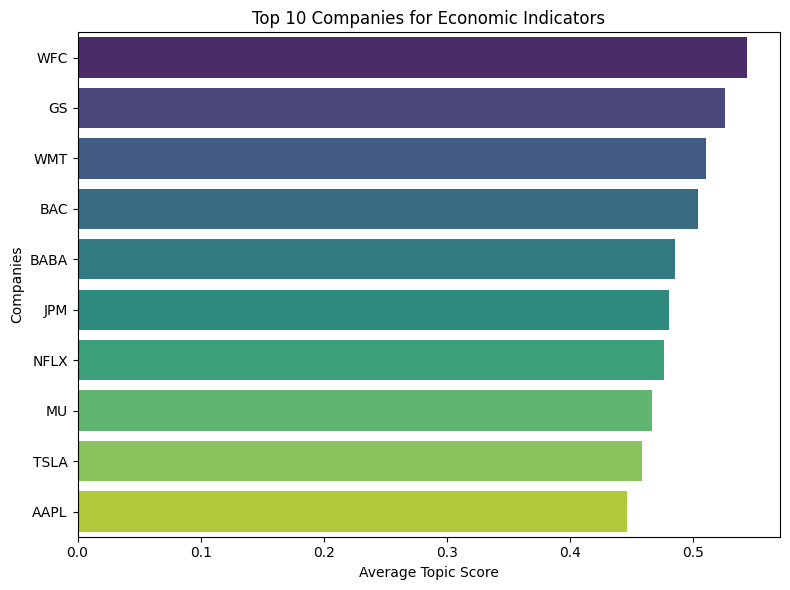

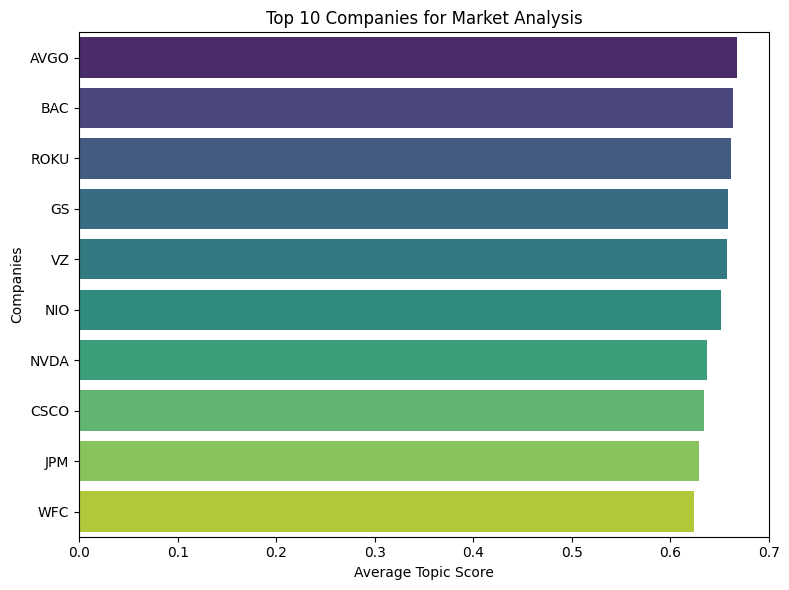

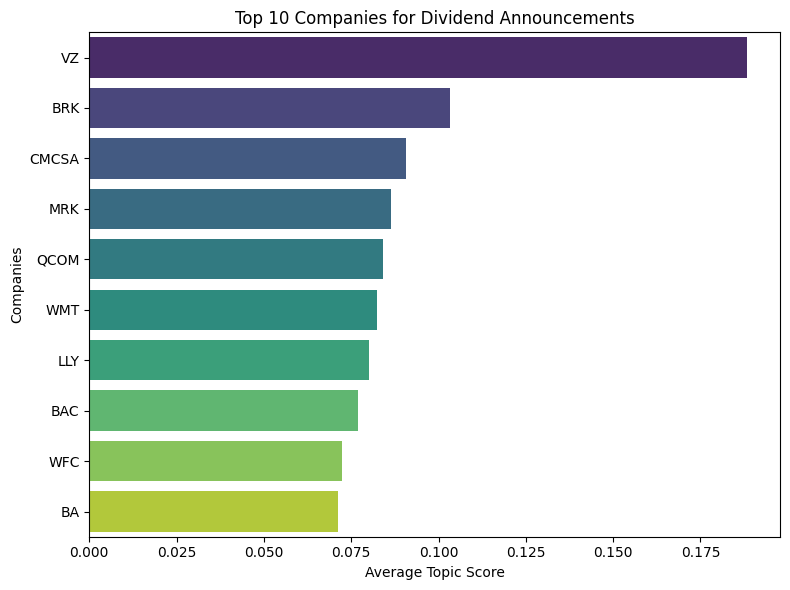

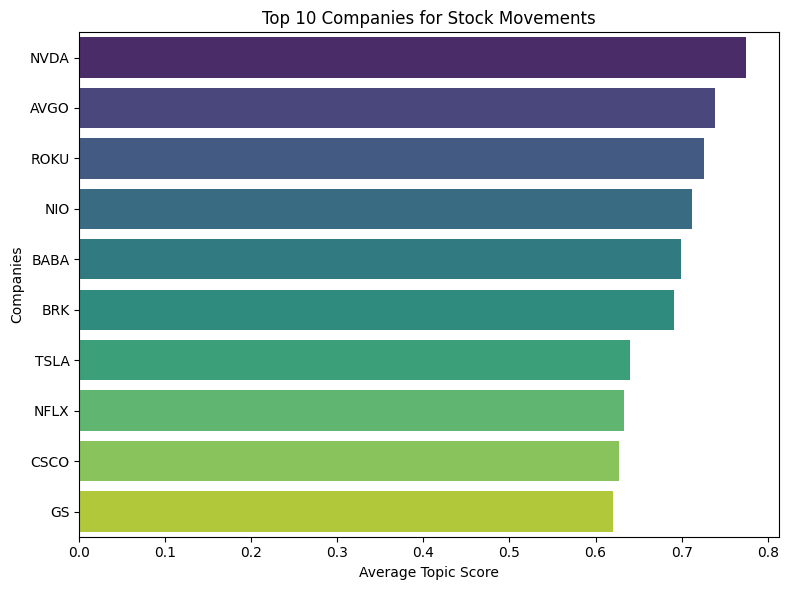

In [113]:
for topic in company_topic_scores.columns[1:]:  # Exclude 'company' column
    top_companies = company_topic_scores.sort_values(by=topic, ascending=False).head(10)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=topic, y='company', data=top_companies, palette='viridis')
    plt.title(f'Top 10 Companies for {topic}')
    plt.xlabel('Average Topic Score')
    plt.ylabel('Companies')
    plt.tight_layout()
    plt.show()

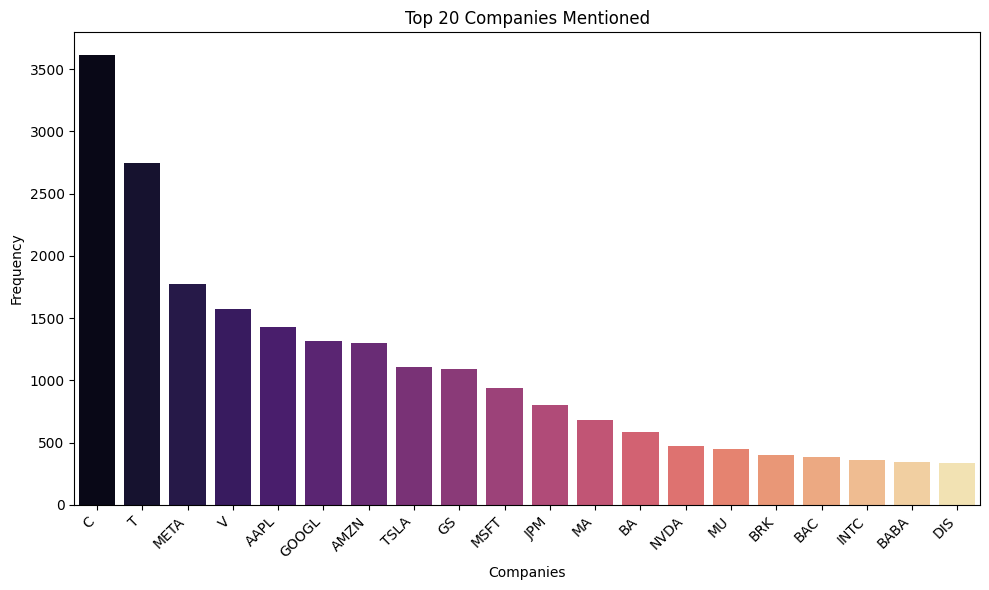

In [114]:
company_counts = topic_df['company'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=company_counts.index, y=company_counts.values, palette='magma')
plt.title('Top 20 Companies Mentioned')
plt.xlabel('Companies')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [117]:
correlation_matrix = company_topic_scores.drop(columns=['company']).corr()  # Exclude irrelevant columns

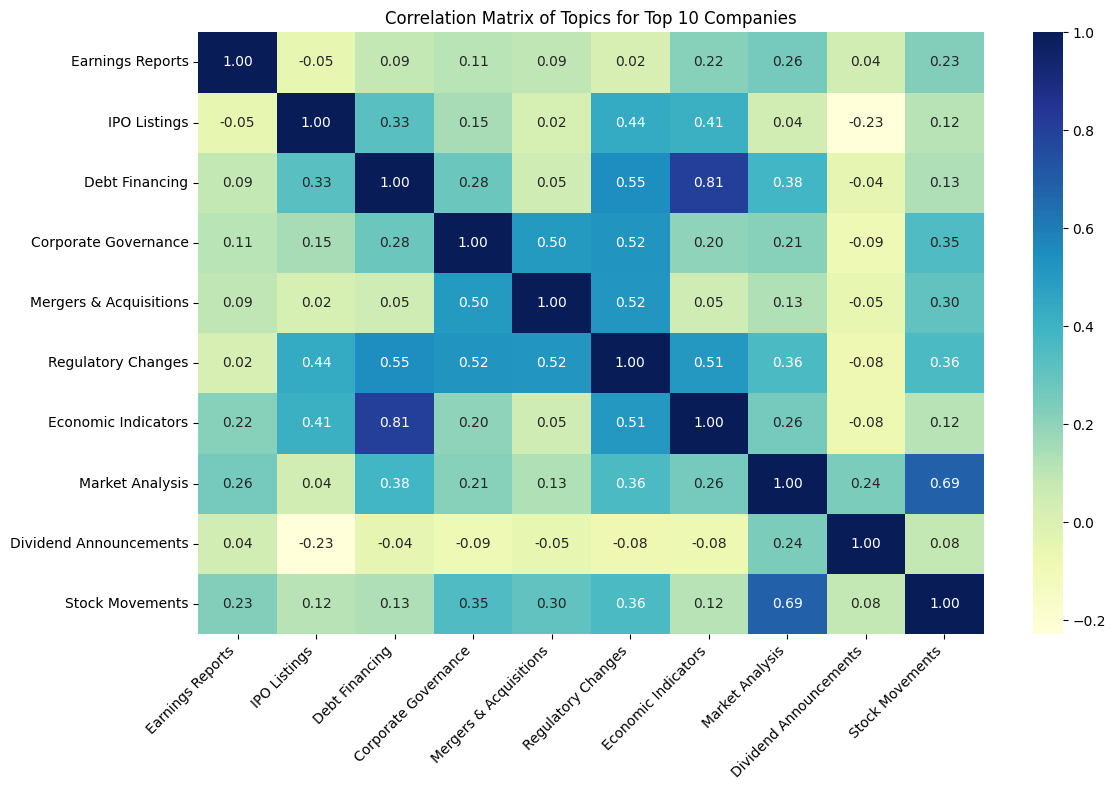

In [118]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title('Correlation Matrix of Topics for Top 10 Companies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [119]:
top_10_companies = topic_df['company'].value_counts().head(10).index.tolist()

In [120]:
filtered_df = topic_df[topic_df['company'].isin(top_10_companies)]

In [122]:
correlation_matrix = filtered_df.drop(columns=['company', 'yearmon']).corr()  # Exclude irrelevant columns

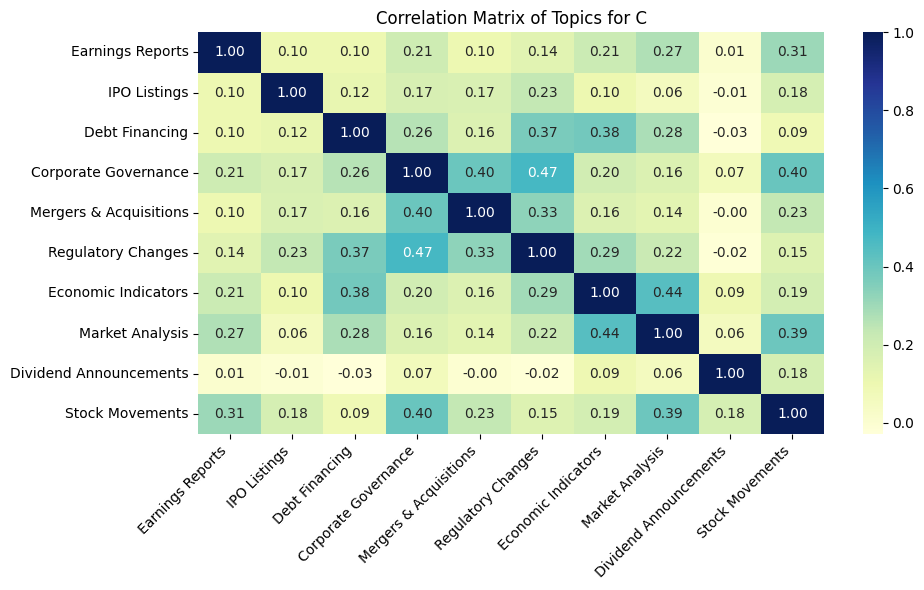

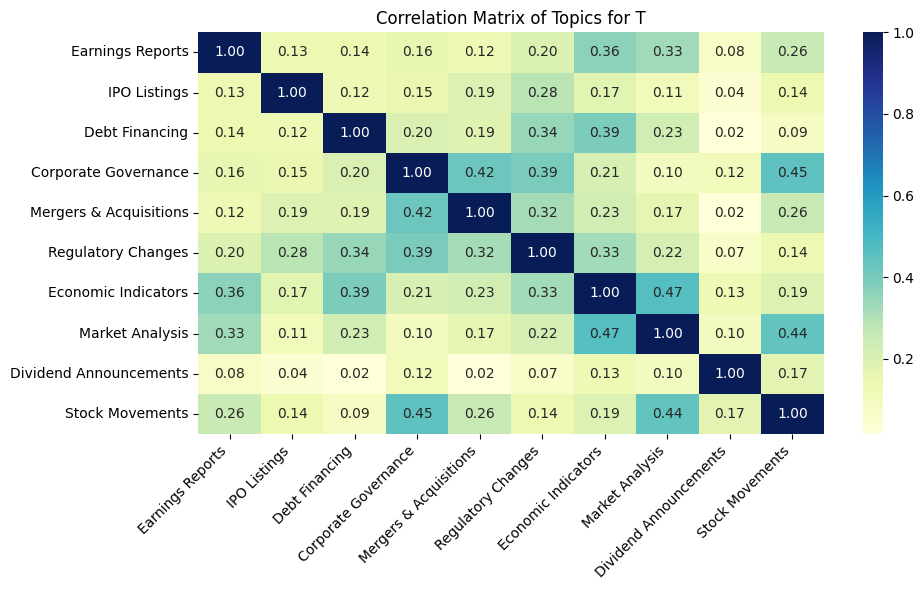

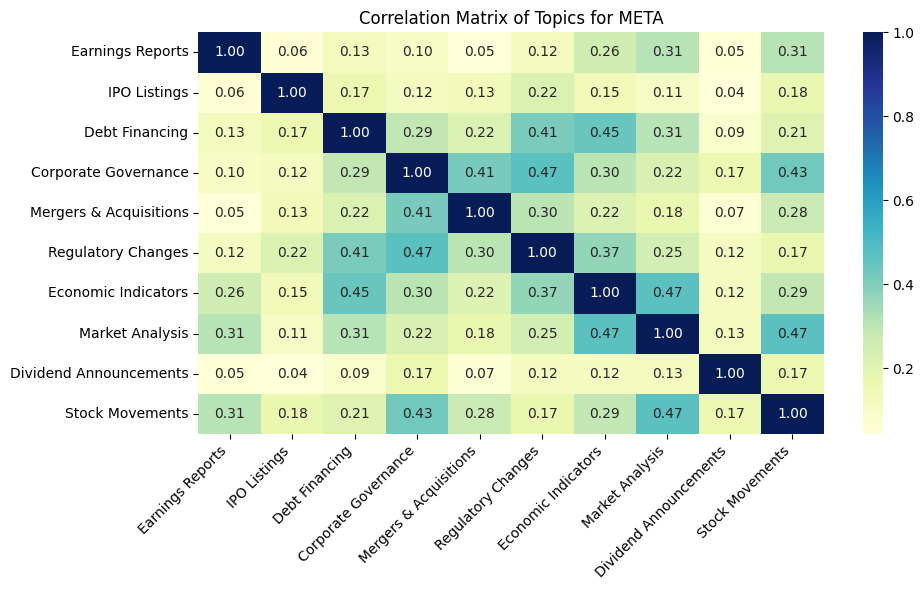

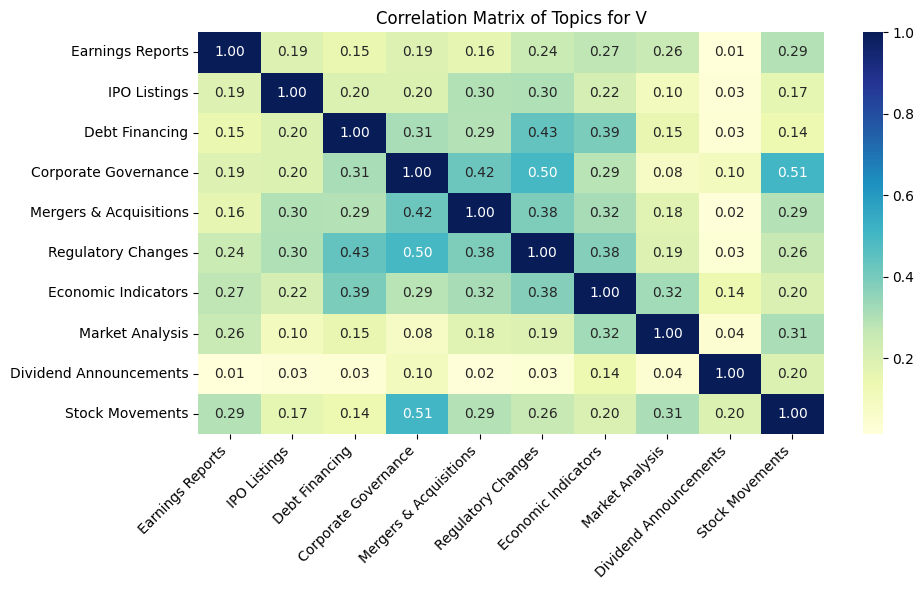

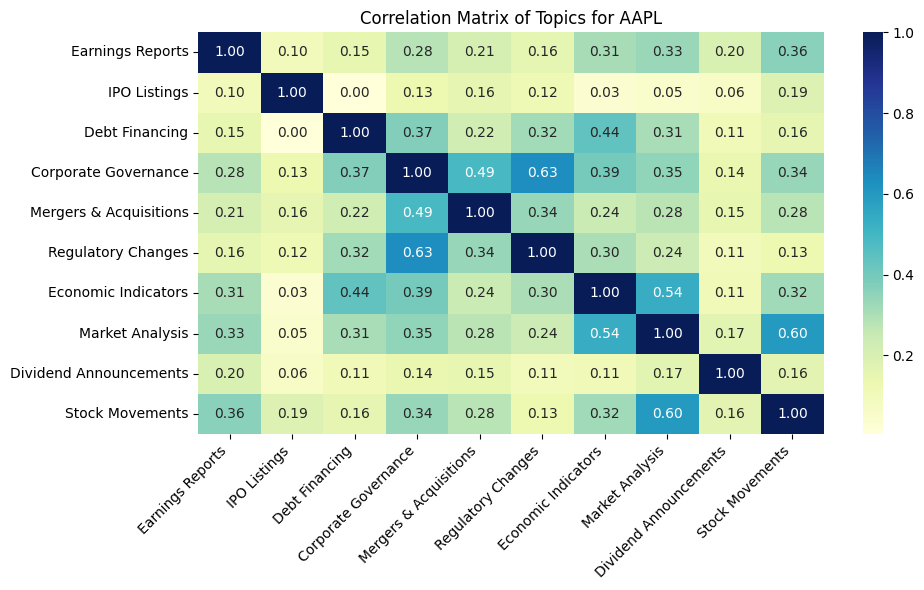

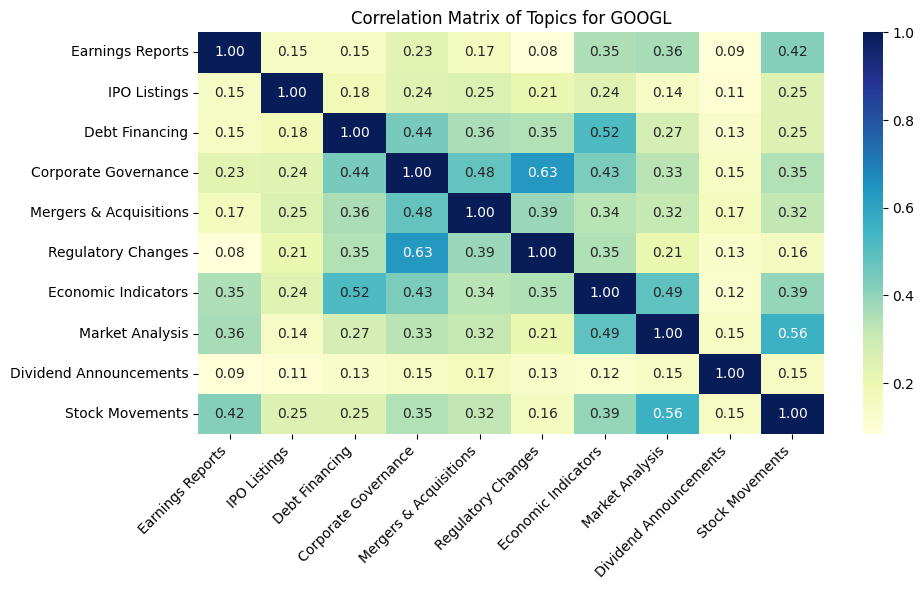

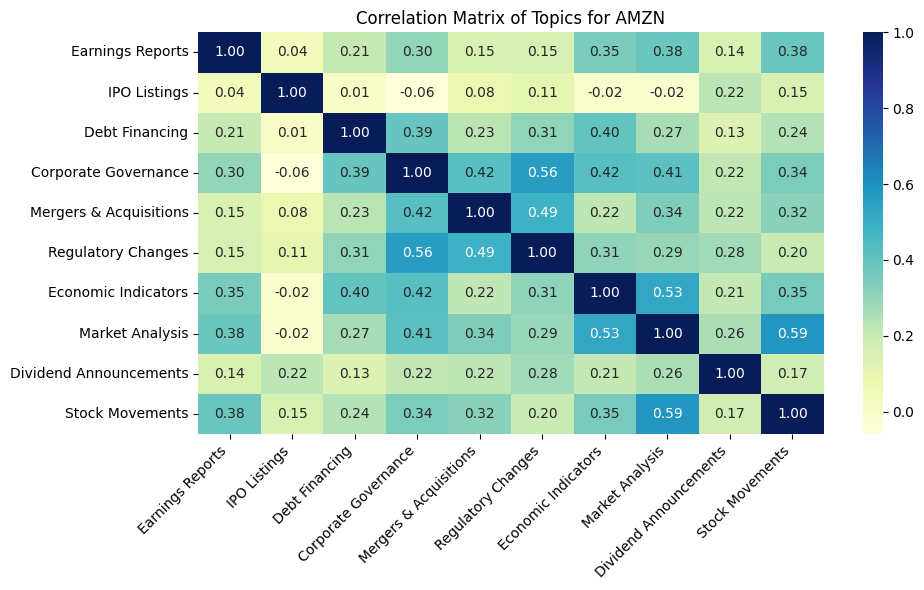

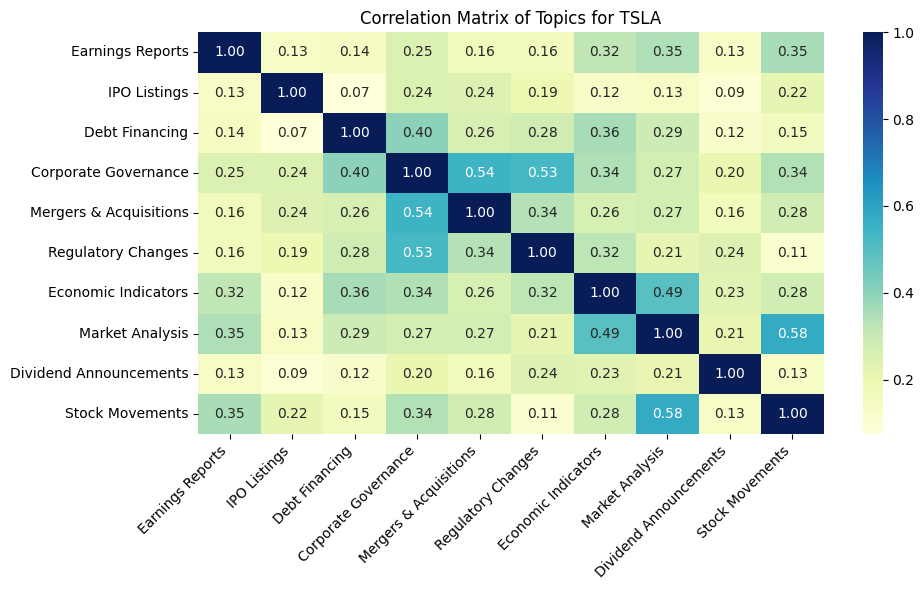

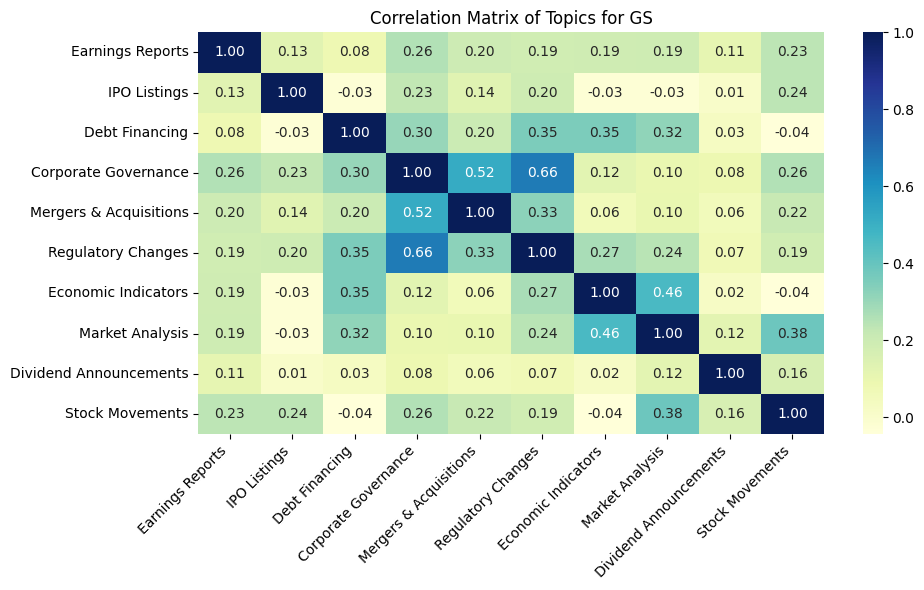

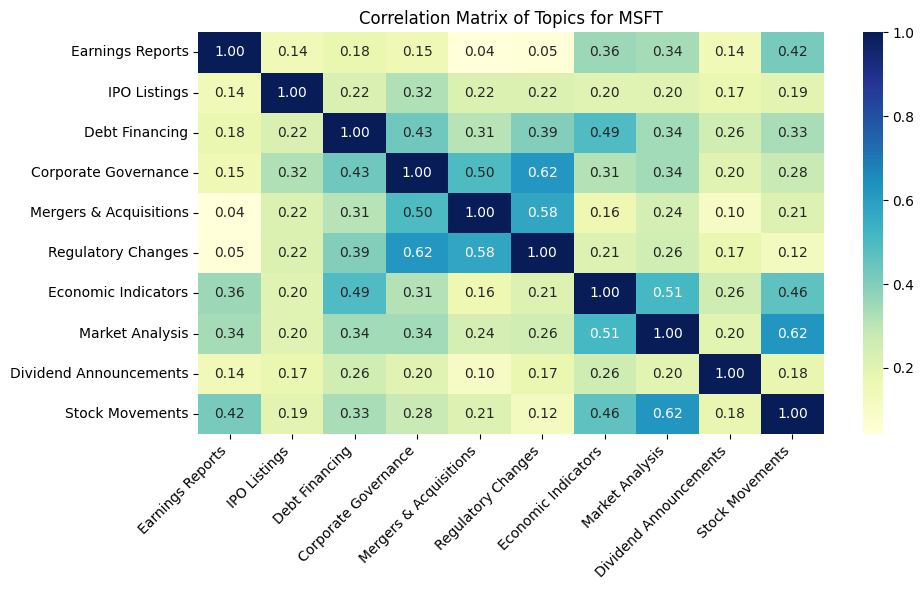

In [126]:
for company in top_10_companies:
    company_df = filtered_df[filtered_df['company'] == company]
    correlation_matrix = company_df.drop(columns=['company', 'yearmon']).corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title(f'Correlation Matrix of Topics for {company}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()